# Machine Learning - Practical 4 - Deep Learning VS Trees


Names: {YOUR NAMES}  
Summer Term 2023   
Due Date: Tuesday, June 13, 2pm

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [51]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

torch.manual_seed(42) # Set manual seed

In [52]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Load, clean and split the tabular dataset

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 20 items. 

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Data description:**  
Data reported to the police about the circumstances of personal injury road accidents in Great Britain from 1979. This version includes data up to 2015. We will try to predict the sex of the driver based on the data provided.

In [53]:
## In case you have any issues with loading the pickle file
## check that your pandas version is 1.4.1
## or just simply run:
## pip install pandas==1.4.1

with open('adopted_road_safety.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [54]:
dataset

,Accident_Index,Vehicle_Reference_df_res,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,201501BS70001,1,19.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,7.0,3,5.0,1.0,0.0,0.0,2.0,0,NaN,NaN
1,201501BS70002,1,9.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,5.0,3,9.0,9.0,0.0,0.0,2.0,0,1.0,3.0
2,201501BS70004,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,6.0,3,1.0,3.0,0.0,0.0,2.0,0,1.0,6.0
3,201501BS70005,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,2.0,3,5.0,1.0,0.0,0.0,2.0,0,1.0,2.0
4,201501BS70008,1,1.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,8.0,2,0.0,0.0,0.0,0.0,0.0,1,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363238,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,1.0,3,0.0,0.0,2.0,0.0,0.0,9,1.0,NaN
363239,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,5.0,3,0.0,0.0,0.0,0.0,0.0,9,1.0,2.0
363240,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,4.0,3,0.0,0.0,0.0,0.0,0.0,9,2.0,5.0
363241,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,6.0,3,0.0,0.0,0.0,0.0,0.0,9,3.0,NaN


In [55]:
target_column = 'Sex_of_Driver'
test_size = 0.2
random_state = 42

In [76]:
def remove_nans(df):
    '''
    This function removes rows with NaN values.
    '''
    # Drop rows with NaN values
    df = df.dropna()  
    return df


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    Change the type of the column to categorical 
    if it has <= n unique values.
    '''
    # Initoate shallow copy of df
    df = df.copy()

    for column in df.columns:

        if column not in ignore:
            # Calculate the number of unique values in the column
            unique_values = df[column].nunique()  

            # Change column type to categorical if condition is met
            if unique_values <= n:
                df.loc[:, column] = df[column].astype('category')  
        else:
            # If the column is in the ignore list, do nothing
            pass

    return df


def remove_columns_by_n(df, n=10, condition=np.number, direction='less', ignore=[target_column]):
    '''
    Remove columns with more or less than n unique values.
    The function can be applied to either categorical or numerical columns based on the provided condition parameter.
    With the default values, it removes all numerical columns that have less than 10 unique values (except for the target_column).
    '''

    if direction not in ['less', 'more']:
        raise ValueError("Invalid direction. Choose either 'less' or 'more'.")

    if condition == 'category':
        filtered_columns = df.select_dtypes(include='category').columns

    elif condition == np.number:
        filtered_columns = df.select_dtypes(include=np.number).columns

    else:
        raise ValueError("Invalid condition. Choose either 'category' or np.number")

    for column in filtered_columns:
        if column not in ignore:
            unique_values = df[column].nunique()

            if direction == 'less' and unique_values < n:
                df.drop(column, axis=1, inplace=True)

            elif direction == 'more' and unique_values > n:
                df.drop(column, axis=1, inplace=True)

    return df

In [77]:
# Disable soft warning!!
# SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame
#pd.options.mode.chained_assignment = None  # default = 'warn'

df = dataset

df = remove_nans(df)

df = numerical_to_categorical(df, n=2, ignore=[target_column])

df = remove_columns_by_n(df, n=10, condition=np.number, direction='less', ignore=[target_column])
df = remove_columns_by_n(df, n=40, condition='category', direction='more', ignore=[target_column])

assert not df.isna().any().any(), 'There are still nans in the dataframe'

In [79]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y

# Split DataFrame into features and target variable
X = df.drop(target_column, axis = 1)
Y = df[target_column]

# Perform train-test split
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=test_size, random_state=random_state)

print("Original dataset dimensions: ", dataset.shape)
print("Preprocessed dataset dimensions: ", df.shape)

Original dataset dimensions:  (363243, 67)
Preprocessed dataset dimensions:  (96326, 29)


**TODO :**  

* Did you split the dataset in a stratified manner or not? Why?
* How did the dataset dimensions change after preprocessing?
* How many unique values are in the response variable? 

## Task 1: Create a GradientBoostingClassifier

In [59]:
## TODO : define the GradientBoostingClassifier, 
## train it on the train set and predict on the test set

# Define GradientBoostingClassifier
model = GradientBoostingClassifier()

# Train the model on train set
model.fit(train_X, train_y)

# Make predictions on test set
predictions = model.predict(test_X)


In [60]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics

# Calculate accuracy
accuracy = accuracy_score(test_y, predictions)

# Calculate precision (change average parameter to 'micro', 'macro', or 'weighted')
precision = precision_score(test_y, predictions, average='weighted')

# Calculate recall (change average parameter to 'micro', 'macro', or 'weighted')
recall = recall_score(test_y, predictions, average='weighted')

# Print the scores
print(f'Accuracy:   {accuracy}')
print(f'Preecision: {precision}')
print(f'Recall:     {recall}')

Accuracy:   0.7742136406104018
Preecision: 0.7687738786803373
Recall:     0.7742136406104018


In [61]:
## TODO : Write a function which iterates over trees_amount, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    for num_trees in trees_amount:
        # Define the GradientBoostingClassifier with the specified number of trees
        model = GradientBoostingClassifier(n_estimators=num_trees)

        # Train the model on the training set
        model.fit(train_X, train_y)

        # Make predictions on the test set
        predictions = model.predict(test_X)

        # Calculate accuracy
        accuracy = accuracy_score(test_y, predictions)

        # Calculate precision
        precision = precision_score(test_y, predictions, average='weighted', zero_division=0)

        # Calculate recall
        recall = recall_score(test_y, predictions, average='weighted')

        # Print the scores
        print(f'Number of Trees: {num_trees}')
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}\n')


In [62]:
#trees_amount_exploration(train_X, train_y, test_X, test_y)

In [63]:
## TODO : Write a function which iterates over the learning rate, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    
    for lr in learning_rates:

        # Define the GradientBoostingClassifier with the specified number of trees
        model = GradientBoostingClassifier(learning_rate = lr, n_estimators = trees_amount)

        # Train the model on the training set
        model.fit(train_X, train_y)

        # Make predictions on the test set
        predictions = model.predict(test_X)

        # Calculate accuracy
        accuracy = accuracy_score(test_y, predictions)

        # Calculate precision
        precision = precision_score(test_y, predictions, average='weighted', zero_division=0)

        # Calculate recall
        recall = recall_score(test_y, predictions, average='weighted')

        # Print the scores
        print(f'Learning Rate: {lr}')
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}\n')

In [64]:
#learning_rate_exploration(train_X, train_y, test_X, test_y)

In [65]:
## TODO : Write a function which iterates over different depths, 
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depe                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          nding on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1,2,3,4,5] , trees_amount = 50):
    
    for depth in depths:
        # Define the GradientBoostingClassifier with the specified depth and number of trees
        model = GradientBoostingClassifier(max_depth = depth, n_estimators = trees_amount)

        # Train the model on the training set
        model.fit(train_X, train_y)

        # Make predictions on the test set
        predictions = model.predict(test_X)

        # Calculate accuracy
        accuracy = accuracy_score(test_y, predictions)

        # Calculate precision
        precision = precision_score(test_y, predictions, average = 'weighted', zero_division = 0)

        # Calculate recall
        recall = recall_score(test_y, predictions, average='weighted')

        # Print the scores
        print(f"Depth: {depth}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}\n")

In [66]:
#max_depth_exploration(train_X, train_y, test_X, test_y)

**TODO :**   

* How does the max_depth parameter influence the results? 
* How does the learning rate influence the results?
* How does the number of trees in the ensemble influence the results?
* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?

In [67]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot

def plot_explained_variance(clf, X):
    # Get feature importances from the classifier
    importances = clf.feature_importances_

    # Get feature names from the feature matrix
    feature_names = X.columns

    # Sort feature importances in descending order
    sorted_indices = importances.argsort()[::-1]
    sorted_importances = importances[sorted_indices][::-1]
    sorted_feature_names = feature_names[sorted_indices][::-1]

    # Create a horizontal bar plot to show relative feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_feature_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

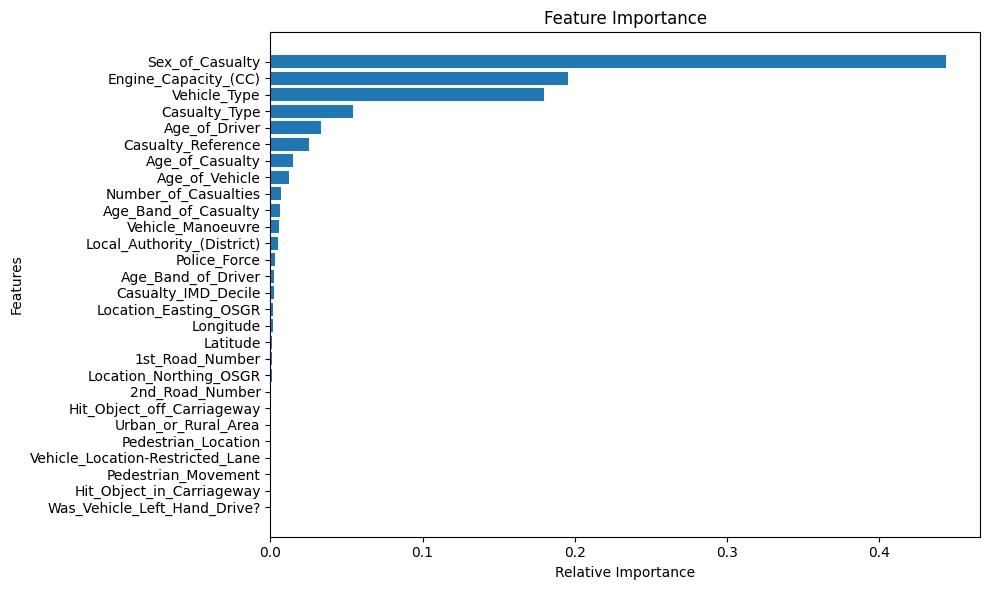

In [68]:
## TODO : display the plot
plot_explained_variance(model, train_X)

**TODO :** Interpret the plot.

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why? 

## Prepare for deep learning
### Add all the necessary training functions 
*You can reuse them from previous practical exercises*

In [69]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3 

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    ratio = correct/total

    return ratio
    

In [70]:
## TODO : Define a train and validation functions here
## Hint - you can use yours from practical 3 

def train(dataloader, optimizer, model, loss_fn, device):
    """
    Method to train the model
    """

    # Set the model to training mode
    model.train()

    # Initialize loss and accuracy variables
    train_loss = 0.0
    correct = 0
    total = 0

    # Iterate over batches in dataloader
    for x, y in dataloader:
        # Move input data and labels to GPU
        x = x.to(device)
        y = y.to(device)

        # Reset gradients of the optimizer to avoid gradient accumulation
        # allows optimizer to perform accurate/independent updates for each batch, resulting in better convergence
        optimizer.zero_grad()

        # Forward pass: compute the predicted outputs of the model
        y_pred = model.forward(x)

        # Compute the loss between the predicted outputs and true labels
        ####################### here was y_pred.squeeze ###################
        loss = loss_fn(y_pred.squeeze(), y)

        # Backward pass: compute the gradients of the model parameters with respect to the loss
        loss.backward()

        # Update the model parameters using the gradients
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

        # Calculate accuracy of the predicted outputs comparing them to true labels
        _, predicted = torch.max(y_pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    # Calculate mean training loss over all batches
    train_loss /= len(dataloader)

    # Calculate training accuracy
    train_accuracy = accuracy(correct, total)

    # Return mean training loss and accuracy
    return train_loss, train_accuracy

In [71]:
## TODO : Define a validation function here
## Hint - you can use yours from practical 3 #

def validate(val_dataloader, model, loss_fn, device):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function
    
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track loss and accuracy
    val_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient computation during validation
    with torch.no_grad():
        # Iterate over the batches in the validation dataloader
        for i, (x_val, y_val) in enumerate(val_dataloader):
            # Move the validation data and labels to the specified device
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            # Forward pass: compute the predicted outputs of the model
            y_pred_val = model(x_val)

            # Compute loss between the predicted outputs and true labels

            ######################### here y_pred_val.squeeze() ####################
            loss_val = loss_fn(y_pred_val.squeeze(), y_val)

            # Accumulate validation loss
            val_loss += loss_val.item()

            # Calculate the accuracy of the predicted outputs by comparing them to true labels
            _, predicted_val = torch.max(y_pred_val.data, 1)
            total += y_val.size(0) # 0 = first dimnesion in tensor
            correct += (predicted_val == y_val).sum().item()

        # Calculate mean validation loss over all batches
        val_loss /= len(val_dataloader)

        # Calculate validation accuracy
        val_accuracy = accuracy(correct, total)

    # Return mean validation loss and accuracy
    return val_loss, val_accuracy

In [72]:
#TODO write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3 

from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, test_dataloader):
    """Method to run the training procedure"""
  # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Iterate over number of epochs using tqdm(trange) for progress bar
    for epoch in trange(num_epochs, desc='Epoch'):
        # Perform training for the current epoch
        train_loss, train_accuracy = train(train_dataloader, optimizer, model, loss_function, device)

        # Perform validation for the current epoch
        val_loss, val_accuracy = validate(test_dataloader, model, loss_function, device)

        # Append the values to repective list
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    # Return lists
    return train_losses, val_losses, train_accs, val_accs

In [73]:
# TODO write a plot function 
## Hint - you can use yours from practical 2 or 3 

def plot_losses(train_losses, val_losses):

    # Create a list of epoch numbers and dataframe to store losses
    epochs = range(1, len(train_losses) + 1)

    # Create data frame with losses and epochs as index
    losses_df = pd.DataFrame({'Epoch': epochs, 'Training Loss': train_losses, 'Validation Loss': val_losses})
    losses_df = losses_df.set_index('Epoch')

    # Set up the plot using seaborn
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 5))

    # Plot both losses
    plt.plot(train_losses, 'o--', label='Train Loss') 
    plt.plot(val_losses, 'o--', label='Validation Loss')

    # Set the plot title and labels
    plt.title('Epoch vs. Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Show the legend
    plt.legend()
    plt.show()

### Convert a pandas dataframe to a PyTorch dataset

In [74]:
## TODO : Define the dataset, apply normalization in the getitem method
## Hint : you can use/adapt your code from practical 2

class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes, 
        x is data without target column
        y is target column
        transform df to_numpy
        ''' 
        self.x = df_x.astype(float)
        self.y = df_y.astype(float).astype(int)
        self.mean = mean
        self.std = std
        self.normalise = normalise
    
    def __len__(self):
        # TODO: return the length of the whole dataset
        return len(self.x)
    
    def __getitem__(self, index):
        ## TODO: return X, y by index, normalized if needed
        data = self.x[index]
        
        if self.normalise and self.mean is not None and self.std is not None:
            data = (data - self.mean) / self.std
        
        return data, self.y[index]

In [75]:
## TODO : calculate mean and std for the train set
## Hint : be careful with categorical values. Convert them them to numerical 
## Hint : the response variable should be of datatype integer


# Separate numerical and categorical variables
train_X_numerical = train_X.select_dtypes(include=np.number)
train_X_categorical = train_X.select_dtypes(include='category')

# Convert categorical to numerical variables
train_X_categorical_converted = train_X_categorical.astype(float)

# Concatenate numerical and encoded categorical columns
train_X = pd.concat([train_X_numerical, train_X_categorical_converted], axis=1)

# Reset indices of train_X and train_y
train_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)

# Calculate mean and standard deviation
train_std = train_X.std()
mean_std_df = pd.DataFrame({'Mean': train_mean, 'Std': train_std})
display(mean_std_df)

# Convert target variable to integer
train_y = train_y.astype(float).astype(int)

NameError: name 'train_mean' is not defined

In [ ]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0!

# Calculate mean and standard deviation for the train set

train_y = train_y.astype(float).astype(int)
train_mean = train_X.mean()
train_std = train_X.std()

print(train_X.shape)
print(train_y.shape)

# Define the training dataset with mean, std, and normalization
train_dataset = TabularDataset(train_X, train_y, normalise=True)

# Define the test dataset with mean, std, and normalization
test_dataset = TabularDataset(test_X, test_y, normalise=True)

# Define dataloaders with the specified batch size and shuffled
batch_size = 256

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


(77060, 14)
(77060,)


## Logistic regression

In [ ]:
class LR(torch.nn.Module):
    """
    The logistic regression model inherits from torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # Define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # Convert input to float32
        x = x.to(torch.float32)
        # Pass data through the linear layer
        outputs = self.linear(x)

        return outputs

In [ ]:
## TODO define model, loss and optimisers
## don't forget to move everything to the correct devices

# Learning rate
lr = 0.001

# Definde input and ouput dimensions
input_dim = train_X.shape[1]
output_dim = 3  # 3 Genders

# Define model
model = LR(input_dim, output_dim)

# Move model to GPU
model.to(device)

# Define loss function
loss_function = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

14
3
cpu


In [ ]:
## TODO train the network
num_epochs = 30
run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, test_dataloader)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
## todo - plot losses and accuracies
plot('Epoch vs. Loss', 'Loss', train_losses_lr, val_losses_lr)

In [ ]:
plot('Epoch vs. Accuracy', 'Accuracy', train_accs_lr, val_accs_lr)


## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?

In [ ]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            # TODO : define 3 linear layer with sizes 
            # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity
            
        )
      

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # TODO

In [ ]:
## TODO : define model, optimiser, cross entropy loss,
## put model to the device, and train mode
## you can optionally apply regularisation between 0.0005 and 0.005 
lr=0.001


In [ ]:
## TODO : Train model
num_epochs = 50


In [ ]:
# TODO plot losses
plot('Epoch vs. Loss', 'Loss', train_losses, val_losses)

In [ ]:
# TODO plot accuracies
plot('Epoch vs. Accuracy', 'Accuracy', train_accs, val_accs)

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why? 


## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimiser. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ 
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/